In [1]:
import deepdish as dd
import numpy as np
from datetime import datetime
import os
from flaregress.io import GOESListHandler, GOESXrayRetriever,LASPf107Retriever, DatabaseHandler
from flaregress.prepare import DataChunker
import pickle
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'deepdish'

# Introduction 

Must be in the "flaregress" directory!

An example of how to chunk data.

# Experiment parameters 

In [23]:
num_flares = 10 # how many flares do you want in your database
history_size = 100 # how much historical GOES data do you want per chunk?

# Setup the data sources 

In [3]:
# save your work as you go here
if not os.path.isdir("trial_data"):
    os.mkdir("trial_data")
    os.mkdir(os.path.join("trial_data","goes"))
    os.mkdir(os.path.join("trial_data","f107"))
    
# get the flare list and pick
flare_list = GOESListHandler().load("./data/goes_list.csv")
chosen_indices = np.random.choice(np.arange(len(flare_list)), num_flares)
flare_list = flare_list.iloc[chosen_indices]

# create retrievers
gxr = GOESXrayRetriever(database_path="./trial_data/goes/db.csv", save_directory="./trial_data/goes/")
fxr = LASPf107Retriever(database_path="./trial_data/f107/db.csv", save_directory="./trial_data/f107/")

# Build the database 

In [4]:
db = DatabaseHandler()
db.build(flare_list, [gxr, fxr])
db.save("./trial_data/db.h5") # we save the database for later (I have this for the FULL dataset)

/home/marcus/.local/lib/python3.6/site-packages/sunpy/lightcurve/lightcurve.py:292: RuntimeWarning: Using existing file rather than downloading, use overwrite=True to override.
  "overwrite=True to override.", RuntimeWarning)
/home/marcus/.local/lib/python3.6/site-packages/deepdish/io/hdf5io.py:234: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  name=level_name, filters=filters, idtable=idtable)


# Perform the chunking! 

In [24]:
chunks, test = DataChunker(db, num_historical_goes=history_size).chunk()
chunks.to_csv("./trial_data/chunks.csv") # we save the chunks for later
pickle.dump(test, open("./trial_data/test.pkl", 'wb'))

Chunks is the chunked data, each row is an entry. Test is the rest of the light curve for that entry that we can test against. If you want, we can easily make this a static horizon for prediction!

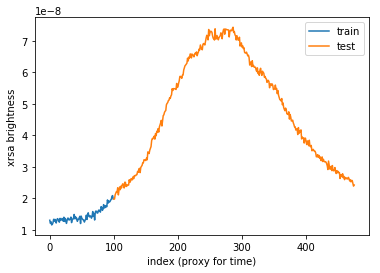

In [28]:
fig, ax = plt.subplots()
index = 1000
this_train = [chunks.iloc[index]['xrsa_{:05d}'.format(i)] for i in range(history_size)]
this_test = test[index]
ax.plot(range(history_size), this_train, label='train')
ax.plot(range(history_size, len(this_test)+history_size), this_test, label='test')
ax.legend()
ax.set_xlabel("index (proxy for time)")
ax.set_ylabel("xrsa brightness")
fig.show()